### Data Exploration

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [4]:
# Load the dataset to inspect its structure
Consumer_Complaints_data = pd.read_csv('C:\\Users\\MARY\\Desktop\\Capstone_Project\\consumer_complaints_analysis\\data_comp.zip', encoding='ISO-8859-1')
# Display the first few rows of the dataset
Consumer_Complaints_data.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [5]:
# Get a summary of the dataset, including data types and non-null counts
Consumer_Complaints_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


## **From info printout we have;**

Number of Rows: 162,421

Number of Columns: 3

Unnamed: 0: Integer column, likely an unnecessary index.

product: Object type, containing categories of financial products.

consumer_complaint_narrative: Object type, containing the complaint text.


**We drop the Unnecessary Index Column: Since Unnamed: 0 is just an index, we can drop it**

In [6]:
#Dropping the Unnecessary Index Column

Consumer_Complaints_data.drop('Unnamed: 0', axis=1, inplace=True)

Consumer_Complaints_data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


 **Check for Missing Values**

In [9]:
# Checking for missing values

Consumer_Complaints_data.isnull().sum()


product       0
narrative    10
dtype: int64

The printout indicates that there are 10 missing values in the narrative column and 0 missing values in the product column.

**Drop Missing Values**

In [10]:
# Drop missing values

Consumer_Complaints_data.dropna(inplace=True)

Consumer_Complaints_data.isnull().sum()

product      0
narrative    0
dtype: int64

**Value Counts: Check the distribution of categories in the product column**

In [11]:
# Check the distribution of categories in the product column

Consumer_Complaints_data['product'].value_counts()

#**Plotting the distribution of categories in the product column**

credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: product, dtype: int64

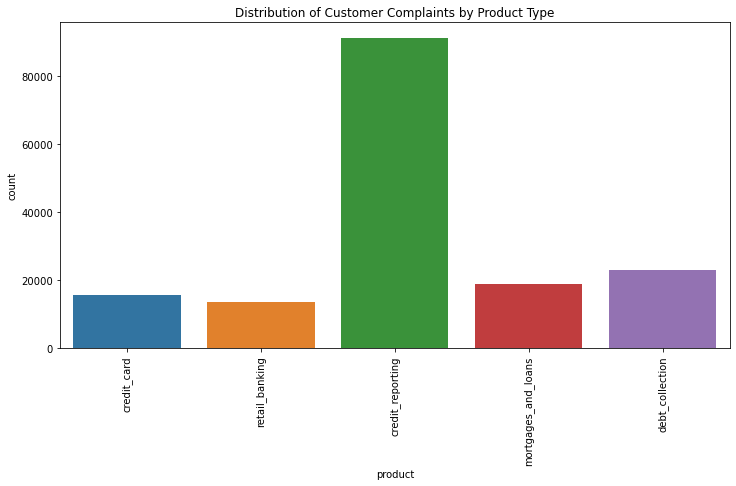

In [13]:
#Bar Plotting the distribution of categories in the product column

plt.figure(figsize=(12,6))
sns.countplot(x='product', data=Consumer_Complaints_data)
plt.xticks(rotation=90)
plt.title('Distribution of Customer Complaints by Product Type')  
plt.show()

**Distribution of Narrative Length**

Text(0.5, 1.0, 'Distribution of Narrative Length')

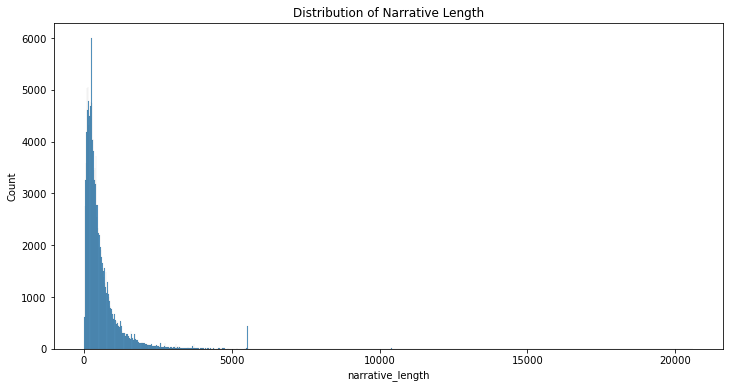

In [15]:
# Distribution of Narrative Length

Consumer_Complaints_data['narrative_length'] = Consumer_Complaints_data['narrative'].apply(lambda x: len(x))

plt.figure(figsize=(12,6))
sns.histplot(x='narrative_length', data=Consumer_Complaints_data)
plt.title('Distribution of Narrative Length')

# **Data Processing**

In [18]:
# Data processing   function    
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs (if any)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = text.split()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing to the 'narrative' column
Consumer_Complaints_data['cleaned_narrative'] = Consumer_Complaints_data['narrative'].apply(preprocess_text)

# Display the DataFrame with cleaned narratives
print(Consumer_Complaints_data[['product', 'narrative', 'cleaned_narrative']])

                 product                                          narrative  \
0            credit_card  purchase order day shipping amount receive pro...   
1            credit_card  forwarded message date tue subject please inve...   
2         retail_banking  forwarded message cc sent friday pdt subject f...   
3       credit_reporting  payment history missing credit report speciali...   
4       credit_reporting  payment history missing credit report made mis...   
...                  ...                                                ...   
162416   debt_collection                                               name   
162417       credit_card                                               name   
162418   debt_collection                                               name   
162419       credit_card                                               name   
162420  credit_reporting                                               name   

                                        cleaned_nar

**Updated Preprocessing Function**

Here’s how you could modify the preprocess_text function to avoid empty cleaned narratives and improve handling:

In [19]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs (if any)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = text.split()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back to string
    cleaned_text = ' '.join(tokens)
    
    # Check if cleaned text is empty, return a placeholder if needed
    if not cleaned_text.strip():
        return "empty"  # or you could use `None` or any other placeholder
    
    return cleaned_text

# Apply preprocessing again
Consumer_Complaints_data['cleaned_narrative'] = Consumer_Complaints_data['narrative'].apply(preprocess_text)

# Display the DataFrame with cleaned narratives
print(Consumer_Complaints_data[['product', 'narrative', 'cleaned_narrative']].head())


            product                                          narrative  \
0       credit_card  purchase order day shipping amount receive pro...   
1       credit_card  forwarded message date tue subject please inve...   
2    retail_banking  forwarded message cc sent friday pdt subject f...   
3  credit_reporting  payment history missing credit report speciali...   
4  credit_reporting  payment history missing credit report made mis...   

                                   cleaned_narrative  
0  purchase order day shipping amount receive pro...  
1  forwarded message date tue subject please inve...  
2  forwarded message cc sent friday pdt subject f...  
3  payment history missing credit report speciali...  
4  payment history missing credit report made mis...  


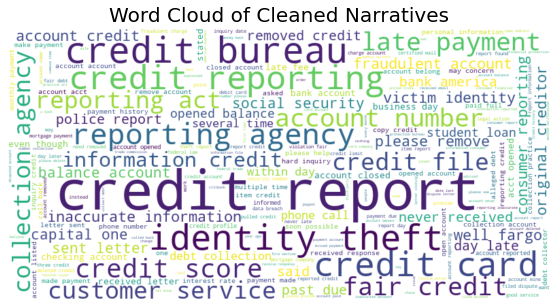

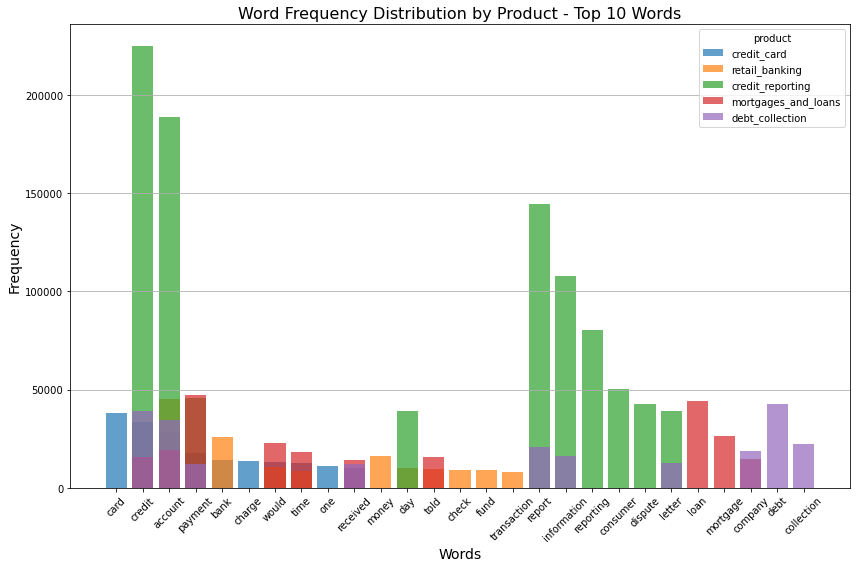

In [21]:

def analyze_text_data(dataframe, text_column, product_column, num_words=20, max_words=200):
    """
    Analyzes text data by generating a word cloud and plotting word frequency distribution by product.

    Parameters:
    - dataframe: pd.DataFrame: The DataFrame containing the text data.
    - text_column: str: The name of the column containing text data.
    - product_column: str: The name of the column containing product information.
    - num_words: int: The number of most common words to display in the histogram.
    - max_words: int: The maximum number of words to display in the word cloud.
    """
    
    # Generate Word Cloud
    def generate_word_cloud():
        # Combine all text from the specified column into a single string
        text = ' '.join(dataframe[text_column].dropna())

        # Create a word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              colormap='viridis', max_words=max_words, random_state=42).generate(text)

        # Display the word cloud using matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title('Word Cloud of Cleaned Narratives', fontsize=20)
        plt.show()

    # Plot Word Distribution by Product
    def plot_word_distribution_by_product():
        # Create a new figure
        plt.figure(figsize=(12, 8))
        
        # Group by product and analyze each product's narrative
        products = dataframe[product_column].unique()
        
        for product in products:
            # Filter narratives for the current product
            product_narratives = dataframe[dataframe[product_column] == product][text_column].dropna()
            # Combine all text into a single string
            text = ' '.join(product_narratives)
            # Tokenize the text
            words = text.split()
            # Count the frequency of each word
            word_counts = Counter(words)
            # Get the most common words
            common_words = word_counts.most_common(num_words)
            # Separate words and counts for plotting
            words, counts = zip(*common_words)

            # Plotting the word distribution for each product
            plt.bar(words, counts, label=product, alpha=0.7)
        
        plt.title(f'Word Frequency Distribution by Product - Top {num_words} Words', fontsize=16)
        plt.xlabel('Words', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(rotation=45)
        plt.legend(title=product_column)
        plt.grid(axis='y')
        plt.tight_layout()  # Adjust layout to make room for the legend
        plt.show()

    # Call the functions
    generate_word_cloud()
    plot_word_distribution_by_product()

# Example usage
# Consumer_complaints_data is our dataframe and it contains 'cleaned_narrative' and 'product' columns.
analyze_text_data(Consumer_Complaints_data, 'cleaned_narrative', 'product', num_words=10, max_words=200)


# **Feature Selection**